# Creating Dashboard with Plotly and Streamlit

In [2]:
# import libraries

import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from datetime import datetime, timedelta
import warnings
import plotly.io as pio
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import io
import base64
warnings.filterwarnings('ignore')

## Wrangle data

In [3]:
df = pd.read_pickle(r"C:\Users\ZenBook\NY_data_merged_seaborn.pkl")

In [4]:
df.dtypes

ride_id                        object
rideable_type                category
started_at             datetime64[ns]
ended_at               datetime64[ns]
start_station_name             object
start_station_id             category
end_station_name               object
end_station_id               category
start_lat                     float32
start_lng                     float32
end_lat                       float32
end_lng                       float32
member_casual                category
date                   datetime64[ns]
avgTemp                       float64
temp_max                      float64
temp_min                      float64
total_precipitation           float64
wind_speed                    float64
value                           int64
month                        category
ride_duration                 float64
dtype: object

In [7]:
# Create a Month column 

df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')
df['Month'] = df['date'].dt.month
df['Month'] = df['Month'].astype('int')

In [10]:
# Create the season column

df['Season'] = [
    "winter" if (m == 12 or 1 <= m <= 4)
    else "spring" if (m == 5)
    else "summer" if (6 <= m <= 9)
    else "fall"
    for m in df['Month']
]

In [11]:
df.shape

(12000000, 24)

In [12]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', 'temp_max', 'temp_min',
       'total_precipitation', 'wind_speed', 'value', 'month', 'ride_duration',
       'Month', 'Season'],
      dtype='object')

## Create the plotly charts

### Bar Chart

In [14]:
## Groupby

df['value'] = 1 
df_groupby_bar = df.groupby('start_station_name', as_index=False).agg({'value': 'sum'})
top15 = df_groupby_bar.nlargest(15, 'value')

In [15]:
top15

,start_station_name,value
1583,W 21 St & 6 Ave,52629
8,1 Ave & E 68 St,48603
494,Broadway & W 58 St,45270
1713,West St & Chambers St,44562
286,6 Ave & W 33 St,41279
1507,University Pl & E 14 St,39656
787,E 33 St & 1 Ave,38674
462,Broadway & E 21 St,38310
460,Broadway & E 14 St,38197
484,Broadway & W 25 St,37979


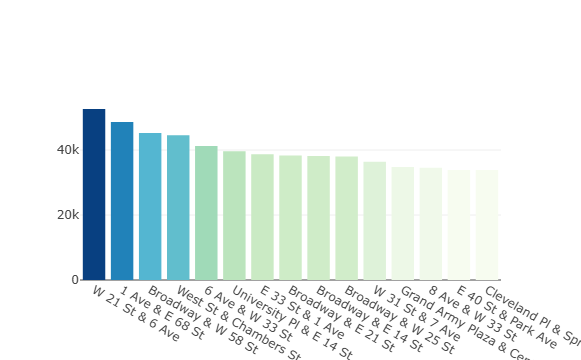

In [19]:
fig = go.Figure(go.Bar(x = top15['start_station_name'], y = top15['value'], marker={'color': top15['value'],'colorscale': 'gnbu'}))
fig.show()

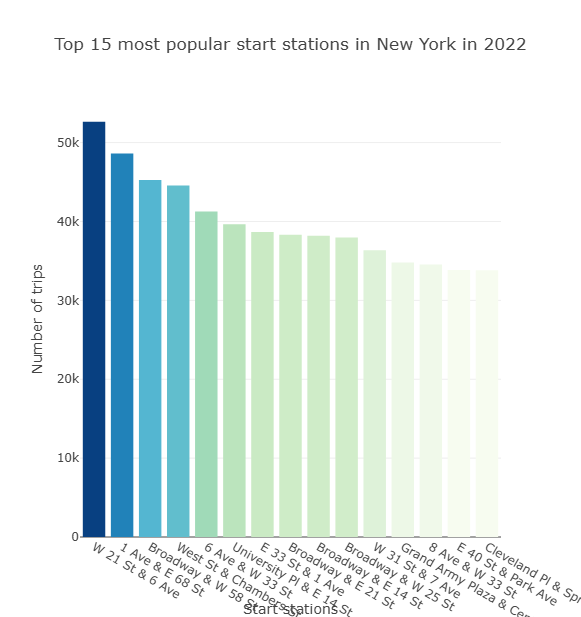

In [22]:
fig.update_layout(
    title = 'Top 15 most popular start stations in New York in 2022',
    xaxis_title = 'Start stations',
    yaxis_title ='Number of trips',
    width = 900, height = 600)

In [23]:
# Save the top15 stations as a CSV file

top15.to_csv('top15_start_NY_2022.csv')

### Dual-Axis Line Chart

In [31]:
# Creating daily aggregation
df_daily = df.groupby('date').agg({
    'ride_id': 'count',
    'avgTemp': 'mean'
}).reset_index()

# Renaming for clarity
df_daily.rename(columns={'ride_id': 'bike_rides_daily'}, inplace=True)

# Setting date as index (optional)
df_daily.set_index('date', inplace=True)

In [32]:
# Ensure df_daily is sorted by date
df_daily = df_daily.sort_index()

# Filter to 2022 only
df_daily = df_daily.loc["2022-01-01":"2022-12-31"]

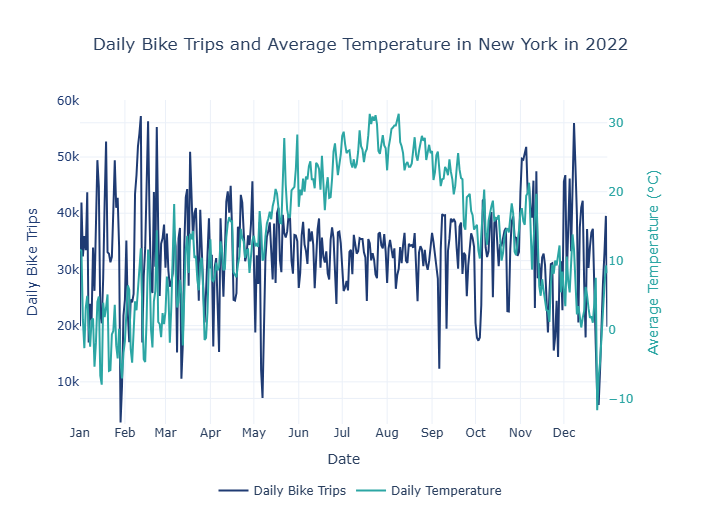

In [45]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(specs=[[{"secondary_y": True}]])

# Daily bike rides (primary axis) 
fig.add_trace(
    go.Scatter(
        x=df_daily.index,
        y=df_daily['bike_rides_daily'],
        name='Daily Bike Trips',
        mode='lines',
        line=dict(color="#1f3b73", width=2)),
    secondary_y=False)

# Daily temperature (secondary axis)
fig.add_trace(
    go.Scatter(
        x=df_daily.index,
        y=df_daily['avgTemp'],
        name='Daily Temperature',
        mode='lines',
        line=dict(color="#2ca6a4", width=2)),
    secondary_y=True)

# Layout 
fig.update_layout(
    title="Daily Bike Trips and Average Temperature in New York in 2022",
    title_x=0.5,
    template="plotly_white",
    height=500,
    width=900,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=-0.25,
        xanchor='center',
        x=0.5))

# Show only month names
fig.update_xaxes(
    title_text="Date",
    dtick="M1",
    tickformat="%b")

# Color the y-axis labels + add padding
fig.update_yaxes(
    title_text="Daily Bike Trips",
    title_font=dict(color="#1f3b73"),
    tickfont=dict(color="#1f3b73"),
    secondary_y=False,
    range=[
        df_daily['bike_rides_daily'].min() * 0.9,
        df_daily['bike_rides_daily'].max() * 1.05])

fig.update_yaxes(
    title_text="Average Temperature (°C)",
    title_font=dict(color="#2ca6a4"),
    tickfont=dict(color="#2ca6a4"),
    secondary_y=True,
    range=[
        df_daily['avgTemp'].min() - 2,
        df_daily['avgTemp'].max() + 2])

fig.show()


In [39]:
import gc # this is a garbage collector
gc.collect()

1860

In [40]:
df.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', 'temp_max', 'temp_min',
       'total_precipitation', 'wind_speed', 'value', 'month', 'ride_duration',
       'Month', 'Season'],
      dtype='object')

In [41]:
# create a copy df with fewer columns

df_1 = df.drop(columns = {'ride_id', 'rideable_type', 'started_at', 'ended_at','start_station_id',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'temp_max', 'temp_min',
       'total_precipitation', 'wind_speed', 'month', 'ride_duration',
       'Month'})

In [42]:
df_1.columns

Index(['start_station_name', 'end_station_name', 'date', 'avgTemp', 'value',
       'Season'],
      dtype='object')

In [43]:
df_1.to_csv('df_1_reduced_data.csv')

In [44]:
# As data for dual-axis linear plot were in other df - save it separately

df_daily.to_csv('df_daily_trips_temp.csv')